In [1]:
import numpy as np
import pandas as pd
import json
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
 ########
##TODO
########

# Analyse the language of the song. Most people only listen to songs in their language or in english
# Parse the release_date
# Investigate the different context_type, platform_name and platform_family
# Create a user-song matrix to infer ratings and features for each song
# Create a feature giving the period of the day (morning, lunch time, afternoon etc.)
# Find the artist/song popularity

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
0,25471,1480597215,222606,41774,12,20040704,1,0,223,0,0,9241,55164,29,0
1,25571,1480544735,250467,43941,0,20060301,2,1,171,0,0,16547,55830,30,1
2,16,1479563953,305197,48078,1,20140714,2,1,149,1,1,7665,2704,29,1
3,7,1480152098,900502,71521,0,20001030,0,0,240,0,1,1580,938,30,0
4,7,1478368974,542335,71718,0,20080215,0,0,150,0,1,1812,2939,24,1


In [5]:
train['listen_type'].mean()

0.30687418191747562

In [6]:
# Count per songs
pd.value_counts(train['media_id']).head(10)

132434634    20148
133165774    17652
132123604    16289
132123626    15131
132123630    14347
129632340    13076
131576046    12709
132614858    12394
134748108    12257
133661814    11663
Name: media_id, dtype: int64

In [7]:
# Count per users
pd.value_counts(train['user_id']).head(10)

0    6317
1    6240
2    6211
3    5581
4    5426
5    5400
6    5398
7    5237
8    5185
9    4989
Name: user_id, dtype: int64

In [8]:
# Import the extra infos about each song
extra_infos = []
with open('extra_infos.json') as json_file:
    for line in json_file:
        extra_infos.append(json.loads(line))

In [9]:
extra_infos[:2]

[{u'alb_title': u'El Son de Cuba',
  u'art_name': u'Septeto Nacional De Ignacio Pineiro',
  u'media_id': 213952,
  u'sng_title': u'Maria Cristina'},
 {u'alb_title': u'Sounds from the fourth world',
  u'art_name': u'Calvin Russell',
  u'media_id': 223014,
  u'sng_title': u'Love stealer'}]

In [10]:
# Convert timestamp (ts_listen)
def convert_ts(ts):
    formatted_date = datetime.datetime.fromtimestamp(
        ts).strftime('%Y-%m-%d %H:%M:%S')
    return(formatted_date)

def parse_ts(X):
    X['ts_listen_fmt'] = X['ts_listen'].map(convert_ts)

    # Parse year/month/day/hour
    X['year_listen'] = pd.DatetimeIndex(X['ts_listen_fmt']).year
    X['month_listen'] = pd.DatetimeIndex(X['ts_listen_fmt']).month
    X['day_listen'] = pd.DatetimeIndex(X['ts_listen_fmt']).day
    X['hour_listen'] = pd.DatetimeIndex(X['ts_listen_fmt']).hour
    
parse_ts(train)
parse_ts(test)

In [11]:
# All but 67 users have their listening history in a single year.
sum(train.groupby('user_id')['year_listen'].nunique() >= 2)

67

In [12]:
# All but 6919 users have their listening history in a single month.
sum(train.groupby('user_id')['month_listen'].nunique() >= 2)

6919

In [13]:
train['year_listen'].unique()

array([2016, 1980, 1970, 2012, 2008, 2015, 2013, 2009, 1996, 2010, 2011,
       2001, 2014])

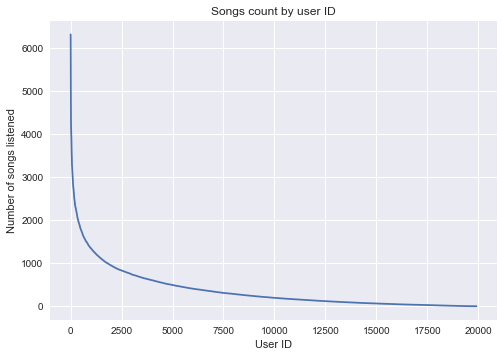

In [14]:
plt.plot(train.groupby('user_id')['is_listened'].count())
plt.xlabel('User ID')
plt.ylabel('Number of songs listened')
plt.title('Songs count by user ID')
plt.show()

The user ID was created with the ranking giving how many songs each user has listened to.

In [15]:
# Is the test set posterior to the train set ?
train_gb = train.groupby('user_id')['ts_listen'].last().reset_index()
test = test.merge(train_gb, how='left', on=['user_id'], suffixes=['', '_train'])

sum(test['ts_listen'] <= test['ts_listen_train'])

0

The test set suggested songs are posterior to the train set.

In [16]:
print('Songs are listened {0:.0f}% of the time on average.'.format(100 * train['is_listened'].mean()))

print('First songs are listened {0:.0f}% of the time on average (Flow).'\
      .format(100 * (train['is_listened'] * train['listen_type']).mean()))

Songs are listened 68% of the time on average.
First songs are listened 18% of the time on average (Flow).


In [17]:
train['is_listened_flow'] = train['listen_type'] * train['is_listened']

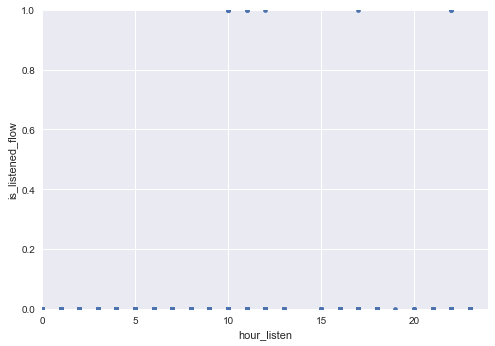

In [18]:
train[train['user_id'] == 40].plot(x='hour_listen', y='is_listened_flow', 
                                   kind='scatter', xlim=(0, 24), ylim=(0, 1))

Some moments in the day are more conducive to flow listening.

In [19]:
count = 0
nb_match = 0
while (count < 100):
    line = test.iloc[count]
    nb_match += line['media_id'] in train[train['user_id'] == line['user_id']]['media_id'].values
    count += 1
print nb_match

34


The suggested songs can be songs the user has already listened to.